### Loading the data using pandas

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/dataset_data.csv")

In [ ]:
df.drop(['Unnamed: 0', 'count', 'offensive_language', 'neither'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text

In [ ]:
df = df.rename(index=str, columns={"class": "op", "tweet": "tweet"})
df.head()

,op,tweet
0,1,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
1,1,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
2,1,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
3,1,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
4,1,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


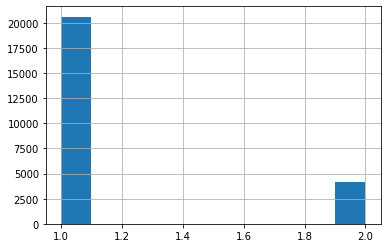

In [ ]:
df['op'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [ ]:
X = df.tweet
Y = df.op
le = LabelEncoder()
Y = le.fit_transform(Y)
print(Y)
Y = to_categorical(Y)
#Y = Y.reshape(-1,1)
print(Y)
print(Y[85])

[0 0 0 ... 1 1 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[1. 0.]


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
#x_train_val=X, y=Y, x_val = X_test, y_val = Y_test

In [ ]:
max_words = 1000
max_len = 1
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Defining the Model

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    #x = Embedding(max_words,50,input_length=max_len)(inputs)
    #x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
    #x = GlobalMaxPool1D()(x)
    #x = Dense(100, activation="relu")(x)
    #x = Dropout(0.25)(x)
    #x = Dense(6, activation="sigmoid")(x)
    #model = Model(inputs=inputs, outputs=x)
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(100,return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(layer)
    layer = Bidirectional(LSTM(100))(layer)
    #layer = GlobalMaxPool1D()(layer)
    layer = Dense(256,name='FC1')(layer)
    #layer = Activation('relu')(layer)
    #layer = Dropout(0.5)(layer)
    
    #layer = Flatten()(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

NameError: ignored

### Custom weight assignment due to class imbalance problem

In [ ]:
class_weight = {0: 50.,
                1: 1.,
                2: 20.}

### Training the model

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=4,validation_data=(X_test,Y_test),class_weight=class_weight)

Epoch 1/4
165/165 [==============================] - ETA: 0s - loss: 1.5514 - accuracy: 0.8314

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

### Evaluating the accuracy of the model

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

3718/3718 [==============================] - 30s 8ms/step


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.788
  Accuracy: 0.762


In [ ]:
y_preds = model.predict(test_sequences_matrix)

In [ ]:
Y_t = []
for i in Y_test:
  Y_t.append(np.argmax(i))
  
#print(Y_t)


Y_p = []

for i in y_preds:
  Y_p.append(np.argmax(i))
  
#print(Y_p)

  

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 

### Displaying the classfication summary

In [ ]:
report = classification_report( Y_t, Y_p )
print(report)

             precision    recall  f1-score   support

          0       0.18      0.55      0.27       212
          1       0.97      0.74      0.84      2885
          2       0.68      0.94      0.79       621

avg / total       0.88      0.76      0.80      3718



### Analyzing the confusion matrix 

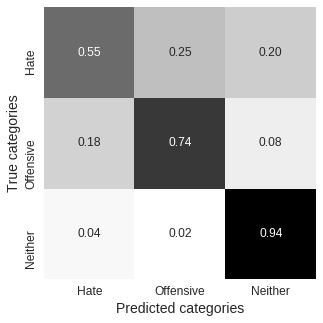

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_t,Y_p)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
